In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install torchutils

In [12]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torchvision import io
import torchutils as tu
import json
import matplotlib.pyplot as plt
import torchvision

In [13]:
device = 'cpu'

In [14]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
    ]
)

**1. Splitting dataset for training and validation**

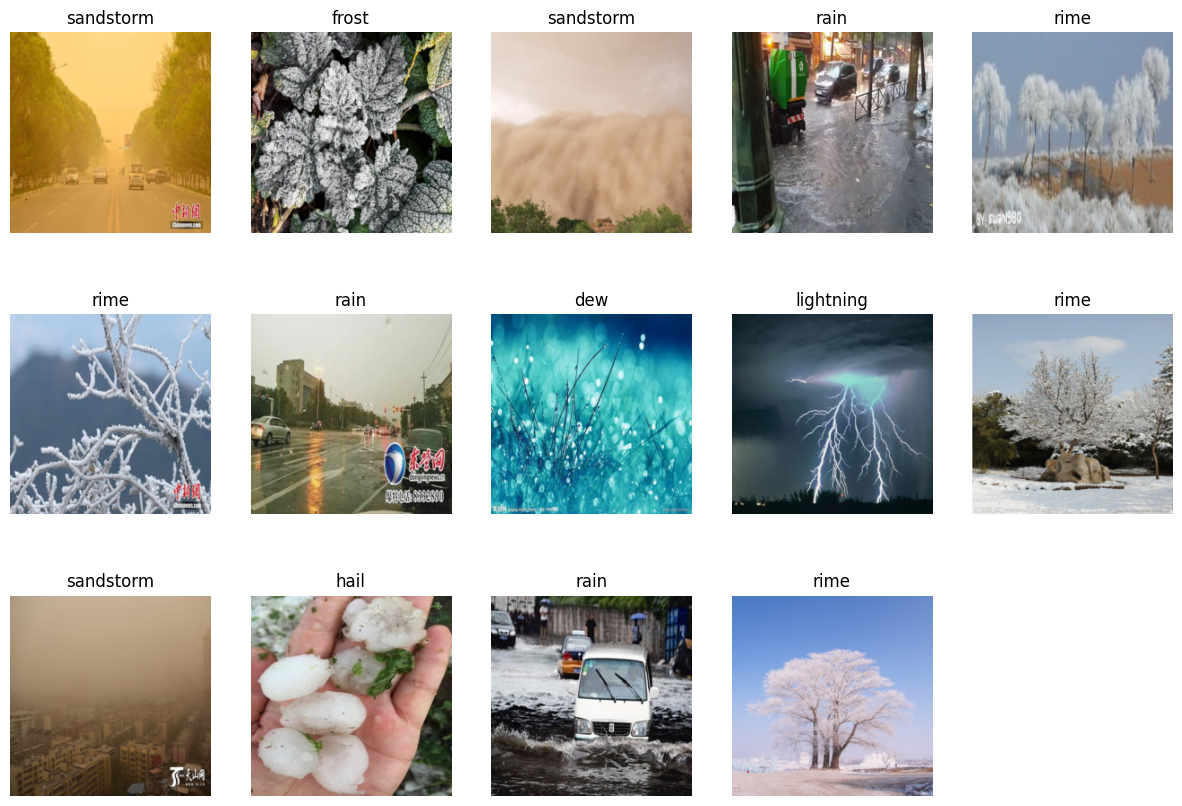

In [15]:
train_dataset = torchvision.datasets.ImageFolder('/kaggle/input/weather-dataset/dataset/',
                                                 transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class_names = train_dataset.classes

plt.figure(figsize=(15, 25))
batch_size = images.size(0)
for i in range(batch_size):
    plt.subplot(7, 5, i+1)
    plt.axis('off')
    plt.imshow(images[i].permute(1, 2, 0))
    plt.title(class_names[labels[i].item()])

In [29]:
class_names

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

In [17]:
train_size = int(0.8 * len(train_dataset))
valid_size = len(train_dataset) - train_size
train_data, valid_data = torch.utils.data.random_split(train_dataset, [train_size, valid_size])

In [18]:
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=True)

**2. Loading with pretraind model. Freezing parametrs, determining the loss function and ond optimizer**

In [ ]:
# Загрузка предобученной модели ResNet18
model = torchvision.models.resnet18(pretrained=True)

In [20]:
# Замена последнего слоя
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 11) # 11 классов для классификации

In [21]:
# Замораживание параметров
for param in model.parameters():
    param.requires_grad = False
model.fc.weight.requires_grad = True
model.fc.bias.requires_grad = True

In [22]:
# Перемещение модели на устройство
model = model.to(device)

# Определение функции ошибки и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

**3. Let's do mini deep learning!**

In [30]:
# Обучение модели
num_epochs = 2
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Оценка точности модели на валидационном наборе данных
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}')

KeyboardInterrupt: 

In [24]:
torch.save(model.state_dict(), 'weather_classification_resnet18.pth')